In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
import pydicom
from scipy.ndimage import zoom
from sklearn.model_selection import KFold
import random
import re

In [2]:
np.random.seed(42)

# CHAOS dataset

In [ ]:
#dicom_file_ex = "/data/groups/public/archive/radiology/multimodal_raw/chaos/Train_Sets/MR/2/T1DUAL/DICOM_anon/InPhase/IMG-0010-00002.dcm"
#dicom_file_ex = "/data/groups/public/archive/radiology/multimodal_raw/chaos/Train_Sets/MR/2/T1DUAL/DICOM_anon/InPhase/IMG-0010-00002.dcm"
dicom_file_ex = "/data/groups/public/archive/radiology/multimodal_raw/chaos/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/IMG-0004-00002.dcm"

ds = pydicom.dcmread(dicom_file_ex)
data = ds.pixel_array
print(data.shape)
print(ds.keys)

# Get DICOM metadata for affine matrix
voxel_size = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))
orientation = np.array(ds.ImageOrientationPatient).reshape(2, 3)
position = np.array(ds.ImagePositionPatient)

# Calculate the affine matrix
affine = np.eye(4)
affine[:3, :2] = orientation.T * voxel_size[:2]
affine[:3, 3] = position

# Ensure data is 3D
if len(data.shape) == 2:
    data = data[np.newaxis, :, :]

# Rescale voxel sizes to 1x1 for x and y axes, maintaining the original slice thickness
new_voxel_size = (1.0, 1.0, voxel_size[2])
zoom_factors = (1.0, new_voxel_size[0] / voxel_size[0], new_voxel_size[1] / voxel_size[1])
resampled_data = zoom(data, zoom_factors, order=1)  # Use linear interpolation For nearest interpolation, use order = 0 (labels!)

# Adjust the affine matrix to reflect the new voxel sizes
new_affine = np.copy(affine)
new_affine[0, 0] = new_voxel_size[0]
new_affine[1, 1] = new_voxel_size[1]
new_affine[2, 2] = voxel_size[2]  # Slice thickness remains the same

# Create a NIfTI image with resampled data and new affine
nifti_img = nib.Nifti1Image(resampled_data, new_affine)

# Copy relevant metadata from DICOM to NIfTI header
header = nifti_img.header
header['pixdim'][1:4] = new_voxel_size

# Save the NIfTI image as a .nii.gz file
new_image_data = nifti_img.get_fdata()
print(new_image_data.squeeze().shape)
print(nifti_img.header)

fig = plt.figure("visualize")
plt.figure(figsize=(5, 2.5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(new_image_data.squeeze(), cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(ds.pixel_array, cmap="gray")
plt.show()

In [ ]:
# Load the image and label NIfTI files
image_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset035_CHAOST1/imagesTr"
label_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset035_CHAOST1/labelsTr"

MRI_images = sorted(glob.glob(os.path.join(image_file_path, "*.nii.gz")))
MRI_labels = sorted(glob.glob(os.path.join(label_file_path, "*.nii.gz")))
print(len(MRI_images))
print(len(MRI_labels))

for image_file, label_file in zip(MRI_images, MRI_labels):
    image = nib.load(image_file)
    label = nib.load(label_file)

    image_data = image.get_fdata()
    label_data = label.get_fdata()

    print(image_data.shape)
    print(image_data.shape)


    # fig = plt.figure("visualize")
    # plt.figure(figsize=(5, 2.5))
    # plt.subplot(1, 3, 1)
    # plt.axis("off")
    # plt.imshow((image_data.squeeze() + label_data.squeeze()) / 2)
    # plt.subplot(1, 3, 2)
    # plt.axis("off")
    # plt.imshow(image_data.squeeze(), cmap="gray")
    # plt.subplot(1, 3, 3)
    # plt.axis("off")
    # plt.imshow(label_data.squeeze())
    # plt.show()


# MRI

In [15]:
def center_crop(data, target_height, target_width):
    """Crop the center of the 3D image data to the target height and width."""
    _, height, width = data.shape
    start_y = (height - target_height) // 2
    start_x = (width - target_width) // 2
    return data[:, start_y:start_y + target_height, start_x:start_x + target_width]

/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/labelsTr/WHSMR_0x0.nii.gz
(220, 220, 1)
(220, 220, 1)


<Figure size 640x480 with 0 Axes>

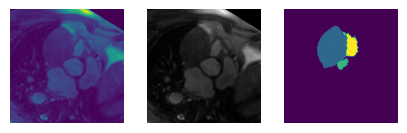

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 220 220   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b'\xd1\x00\x00\x00\x00\x9d\xac\x05\xd1\x00\x00\x00U\xde\x9d\xa9\xf7\x7f'
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.5923126
quatern_c       : 0.009594338
quatern_d       : -0.6520181
qoffset_x       : -179.

In [2]:
# Load the image and label NIfTI files
image_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/imagesTr/"
label_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/labelsTr/"

MRI_images = sorted(glob.glob(os.path.join(image_file_path, "*.nii.gz")))
MRI_labels = sorted(glob.glob(os.path.join(label_file_path, "*.nii.gz")))
print(MRI_labels[0])


i = 0
for image_file, label_file in zip(MRI_images, MRI_labels):
    image = nib.load(image_file)
    label = nib.load(label_file)

    image_data = image.get_fdata()
    label_data = label.get_fdata()

    print(image_data.shape)
    print(label_data.shape)
    fig = plt.figure("visualize")
    plt.figure(figsize=(5, 2.5))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow((image_data.squeeze() + label_data.squeeze()) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(image_data.squeeze(), cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(label_data.squeeze())
    plt.show()
    
    print(image.header)
    break 
    if i == 10:
        break
    else:
        i += 1


In [21]:
# Load the image and label NIfTI files
image_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/imagesTr/"
label_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/labelsTr/"

MRI_images = sorted(glob.glob(os.path.join(image_file_path, "*.nii.gz")))
MRI_labels = sorted(glob.glob(os.path.join(label_file_path, "*.nii.gz")))
print(MRI_labels[0])

i = 0
for image_file, label_file in zip(MRI_images, MRI_labels):
    image = nib.load(image_file)
    label = nib.load(label_file)

    image_data = image.get_fdata()
    label_data = label.get_fdata()

    print(image_data.shape)
    print(label_data.shape)
    print(image.header)
    break

    if i == 10:
        break
    else:
        i += 1


/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/labelsTr/WHSMR_0x0.nii.gz
(220, 220, 1)
(220, 220, 1)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 220 220   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b'\xd1\x00\x00\x00\x00\x9d\xac\x05\xd1\x00\x00\x00U\xde\x9d\xa9\xf7\x7f'
qform_code      : scanner
sform_cod

In [17]:
directory_b = "/data/groups/public/archive/radiology/multimodal_raw/Dataset034_MMWHSMRI/"
directory_b2 = os.path.join(directory_b, "labelsTrAll")
labels = sorted(glob.glob(os.path.join(directory_b2, "*.nii.gz")))
# Define the mapping of old values to new values
label_mapping = {
    # 0: 0,
    # 1: 1,
    2.: 0.,
    3.: 0.,
    4.: 0.,
    5.: 0.,
}

i = 0

os.makedirs(os.path.join(directory_b, "labelsTr"), exist_ok=True)
for file in labels:
    # Use re.sub to replace 'labelsTrOld' with 'labelsTr'
    new_path = re.sub(r'labelsTrAll', 'labelsTr', file)
    # Load the NIfTI file
    lab = nib.load(file)
    data = lab.get_fdata()
    print(np.unique(data))
    # Replace the values in the data array
    for old_value, new_value in label_mapping.items():
        print(old_value, new_value)
        print(data.dtype)
        data[np.isclose(data, old_value)] = new_value
    
    print(np.unique(data))

    break
    # Create a new NIfTI image with the modified data
    new_lab = nib.Nifti1Image(data, lab.affine, lab.header)

    # Save the new NIfTI image to a file
    nib.save(new_lab, new_path)


[0. 1. 2. 3. 4. 5.]
2.0 0.0
float64
3.0 0.0
float64
4.0 0.0
float64
5.0 0.0
float64
[0. 1.]


# CT

(220, 220, 1)
(220, 220, 1)


<Figure size 640x480 with 0 Axes>

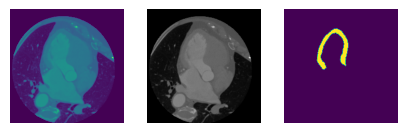

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 220 220   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b'I\x00\x00\x00\x00\xa1\xecpI\x00\x00\x00U\xde\x9d\xa9\xf7\x7f'
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.5923126
quatern_c       : 0.009594338
quatern_d       : -0.6520181
qoffset_x       : -179.55307
qof

In [28]:
# Load the image and label NIfTI files
image_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset033_MMWHSCT/imagesTr"
label_file_path = "/data/groups/public/archive/radiology/multimodal_raw/Dataset033_MMWHSCT/labelsTr"

MRI_images = sorted(glob.glob(os.path.join(image_file_path, "WHSCT_1*.nii.gz")))
MRI_labels = sorted(glob.glob(os.path.join(label_file_path, "WHSCT_1*.nii.gz")))

for image_file, label_file in zip(MRI_images, MRI_labels):
    image = nib.load(image_file)
    label = nib.load(label_file)

    image_data = image.get_fdata()
    label_data = label.get_fdata()

    print(image_data.shape)
    print(label_data.shape)
    fig = plt.figure("visualize")
    plt.figure(figsize=(5, 2.5))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow((image_data.squeeze() + label_data.squeeze()) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(image_data.squeeze(), cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(label_data.squeeze())
    plt.show()

    print(image.header)
    break


In [23]:
cases = range(0,20)
kf = KFold(n_splits=5, shuffle=True)
kf2 = KFold(n_splits=5, shuffle=True)

for i, (fold_trainval, fold_test) in enumerate(kf.split(cases)):
        print(f"Fold {i}")
        random.shuffle(fold_trainval)
        fold_train = fold_trainval[:13]
        fold_val = fold_trainval[13:]
        print("TRAIN")
        print(fold_train)
        print("VAL")
        print(fold_val)
        print("TEST")
        print(fold_test)


Fold 0
TRAIN
[ 5 11  8 17 10  7  6  0 19  9  1 12 16]
VAL
[14  4 18]
TEST
[ 2  3 13 15]
Fold 1
TRAIN
[ 2 17  3 15  6 14 19  1  4  8  7  0 16]
VAL
[ 9 11 13]
TEST
[ 5 10 12 18]
Fold 2
TRAIN
[ 4  6 17 18 12 13  0  3  8 10 16  5 11]
VAL
[ 9  2 15]
TEST
[ 1  7 14 19]
Fold 3
TRAIN
[ 5 18  6 10 19  0  1  3  2  7 13 15 12]
VAL
[ 4  9 14]
TEST
[ 8 11 16 17]
Fold 4
TRAIN
[ 8 19 12 18  1  3  5 11 10 16 17  7 14]
VAL
[ 2 15 13]
TEST
[0 4 6 9]


# Check preprocessed

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

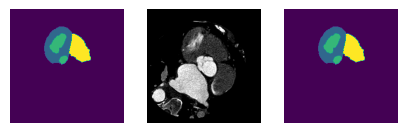

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

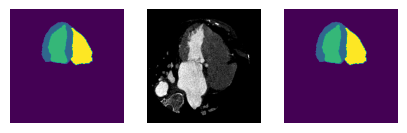

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

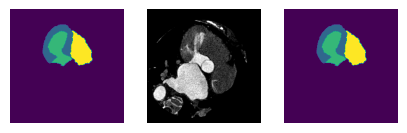

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

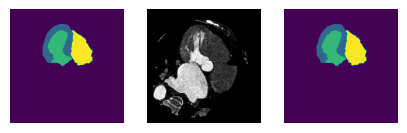

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

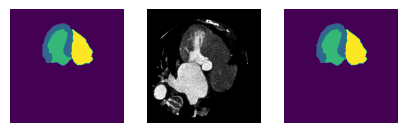

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

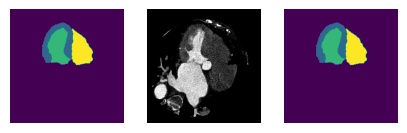

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

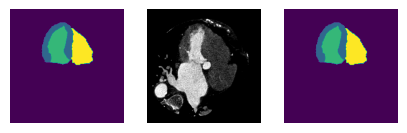

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

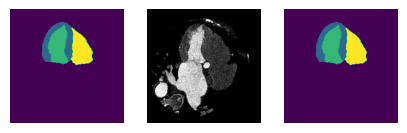

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

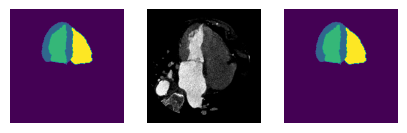

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

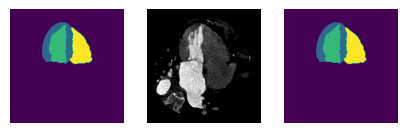

(1, 1, 220, 220)
(1, 1, 220, 220)


<Figure size 640x480 with 0 Axes>

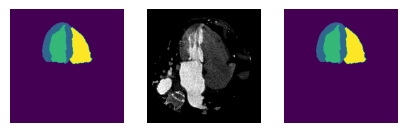

In [12]:
# Load the image and label NIfTI files
# file_path = "nnUNet_preprocessed/Dataset034_MMWHSMRI/nnUNetPlans_2d/"
file_path = "nnUNet_preprocessed/Dataset033_MMWHSCT/nnUNetPlans_2d/"
file_seg_path = "nnUNet_preprocessed/Dataset033_MMWHSCT/gt_segmentations/"


MRI_data = sorted(glob.glob(os.path.join(file_path, "*.npz")))
MRI_segs = sorted(glob.glob(os.path.join(file_seg_path, "*.nii.gz")))


i=0
for file, seg_nii in zip(MRI_data, MRI_segs):
    seg_folder = nib.load(seg_nii)
    seg_data = seg_folder.get_fdata()
    data = np.load(file)
    # image_data = data
    # label_data = data
    image_data = data['data']
    label_data = data['seg']

    print(image_data.shape)
    print(label_data.shape)
    fig = plt.figure("visualize")
    plt.figure(figsize=(5, 2.5))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow((seg_data))
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(image_data.squeeze().T, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(label_data.squeeze().T)
    plt.show()
    if i == 10:
        break
    else:
        i += 1

    # print(image.header)